## Import needed libraries

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, cv
from sklearn.feature_selection import VarianceThreshold
from sentence_transformers import SentenceTransformer, SparseEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


SEED = 123
K_FOLDS = 5

## Import train and/or test data

Here, we import train and test data which are summarized and cleaned of grammatical errors.

In [2]:
CLEAN_DATA_PATH = 'pfacouetey/DSTI_Deep_Learning_Project_2025' # Data path to get clean datasets

TRAIN_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/train2.feather' # Train data path
TEST_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/test2.feather' # Test data path

In [3]:
train_df = pd.read_feather(TRAIN_DATA_PATH)
test_df = pd.read_feather(TEST_DATA_PATH)

In [4]:
train_df.shape[0], test_df.shape[0]

(64000, 16000)

In [5]:
train_df.head()

,text,label
0,30 or 40? I am looking for subs for seasoned a...,alcoholism
1,I need help. Does anyone have any tips for hel...,bpd
2,"advice Hello all, I do not know if this is all...",bpd
3,I was sexually assaulted ok so recently got di...,ptsd
4,My brain is so foggy and I’m exhausted. My bra...,EDAnonymous


In [6]:
train_df['label'].value_counts(normalize=True)

label
adhd             0.063641
healthanxiety    0.062828
bipolarreddit    0.062750
socialanxiety    0.062687
bpd              0.062641
normal           0.062578
autism           0.062516
ptsd             0.062500
suicidewatch     0.062484
depression       0.062484
alcoholism       0.062484
anxiety          0.062437
lonely           0.062141
EDAnonymous      0.062047
schizophrenia    0.062031
addiction        0.061750
Name: proportion, dtype: float64

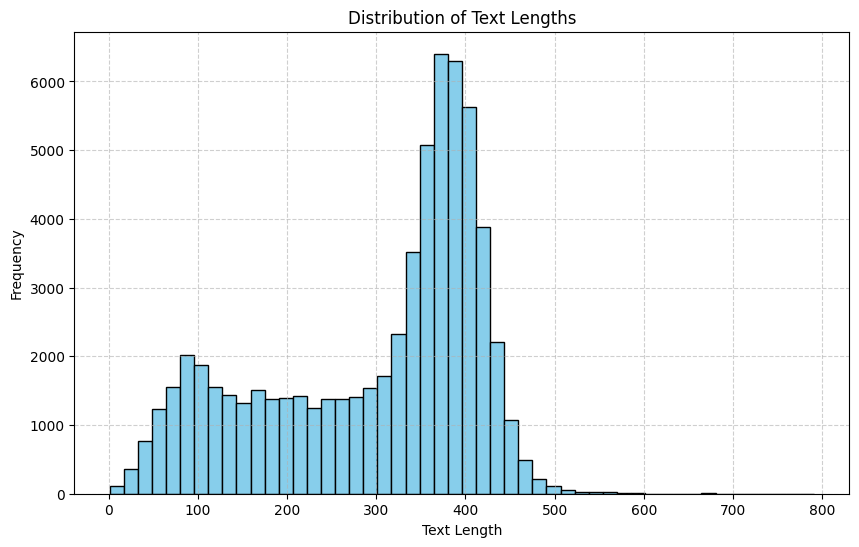

In [7]:
# Distribution of the text_length in column 'text'
train_df['text_length'] = train_df['text'].str.len
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
train_df['text_length'].describe()

count    64000.000000
mean       297.476484
std        120.533347
min          1.000000
25%        201.000000
50%        347.000000
75%        390.000000
max        791.000000
Name: text_length, dtype: float64

Quite short to very long paragraphs are among the texts.

## Text engineering

- Before imputing this text as input into any classical ML model, we need to vectorize it into numerical features that can describe it.
- We use the python framework [SentenceTransformers](https://www.sbert.net/) which maps sentences & paragraphs to a fixed dimensional vector space. There's two ways mentionned in its documentation to compute embeddings, and both are quite interesting to use :
    - A dense numerical representation up to a 768 dimensional space.
    - A sparse numerical representation up to a 30522 dimensional space (we will only keep the first 1000 dimensional space since our local memory can't hold up much).
- For dense representation, we use the ['intfloat/multilingual-e5-base' model](https://huggingface.co/intfloat/multilingual-e5-base), whereas for sparse encodings we use the ['opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini' model](https://huggingface.co/opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini). They are some default pretrained models which offer quite good and quick results, and are also easy to load without requirements of any identification.

In [9]:
MAX_DIM_DENSE, MAX_DIM_SPARSE = 768, 1000
dense_model = SentenceTransformer('intfloat/multilingual-e5-base')
sparse_model = SparseEncoder("opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini")

In [10]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time
try:
    dense_train_encodings_df = pd.DataFrame(np.load('dense_train_encodings.npy'))
except FileNotFoundError:
    dense_train_encodings_df = dense_model.encode(sentences=train_df['text'], truncate_dim=MAX_DIM_DENSE, show_progress_bar=True)
    np.save('dense_train_encodings.npy', dense_train_encodings_df)
    dense_train_encodings_df = pd.DataFrame(dense_train_encodings_df)    

# Downcast numeric columns to reduce memory usage
dense_train_encodings_df = dense_train_encodings_df.select_dtypes(include=[float, int]).astype('float32')

assert dense_train_encodings_df.shape[1] == MAX_DIM_DENSE

dense_train_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.010454,0.022132,-0.017872,0.022576,0.030719,-0.074737,-0.051401,-0.016266,0.016295,0.029604,...,-0.044344,-0.004405,0.024192,0.004471,0.002153,-0.001047,0.057707,-0.044976,-0.026662,0.046026
1,0.004526,0.053869,-0.011672,0.036196,0.033554,-0.037185,-0.042378,-0.044634,0.037963,0.009397,...,-0.048705,-0.000429,0.015686,0.020657,0.009065,-0.000223,0.023646,-0.033216,-0.039654,0.066026
2,0.017393,0.039479,-0.011835,0.028258,0.024650,-0.044176,-0.032944,-0.041170,0.022362,-0.007231,...,-0.045193,0.003043,0.035016,-0.005136,-0.002572,0.020034,0.072868,-0.042625,-0.056678,0.022922
3,0.032301,0.013295,-0.011241,0.017284,0.038064,-0.046494,-0.009671,-0.041209,0.020466,0.027625,...,-0.052720,-0.023492,0.027496,0.008942,0.010808,-0.011768,0.011362,-0.022393,-0.039663,0.025264
4,0.003113,0.020775,-0.001817,0.040567,0.019648,-0.038842,-0.027129,-0.025854,0.026273,-0.003726,...,-0.040153,0.006542,0.014704,-0.009595,0.013242,0.033796,0.026687,-0.033811,-0.032399,0.056593


In [11]:
dense_train_encodings_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,...,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,0.007189,0.044106,-0.005067,0.015785,0.024569,-0.045863,-0.025081,-0.031389,0.024177,0.007339,...,-0.039727,0.001908,0.024989,0.009493,0.013018,-0.001413,0.041024,-0.028087,-0.037675,0.037302
std,0.014990,0.014943,0.012874,0.016175,0.016299,0.016567,0.014324,0.013566,0.016400,0.016309,...,0.015349,0.016282,0.014095,0.015819,0.015480,0.014933,0.016306,0.014889,0.015309,0.016584
min,-0.057021,-0.016492,-0.063406,-0.054979,-0.048846,-0.112722,-0.091831,-0.087640,-0.049999,-0.058453,...,-0.108692,-0.065492,-0.030293,-0.055815,-0.060823,-0.072166,-0.035840,-0.102783,-0.105134,-0.030804
25%,-0.002899,0.034204,-0.013594,0.004865,0.013692,-0.057089,-0.034820,-0.040518,0.013155,-0.003706,...,-0.050123,-0.008998,0.015469,-0.001181,0.002560,-0.011498,0.030049,-0.037979,-0.048016,0.026054
50%,0.007255,0.044160,-0.005112,0.015677,0.024631,-0.046187,-0.025194,-0.031349,0.024145,0.007261,...,-0.039875,0.001708,0.024927,0.009619,0.012835,-0.001467,0.040925,-0.027807,-0.037629,0.037273
75%,0.017339,0.054260,0.003507,0.026552,0.035645,-0.035072,-0.015471,-0.022326,0.035264,0.018202,...,-0.029538,0.012738,0.034454,0.020311,0.023381,0.008661,0.051962,-0.017932,-0.027433,0.048435
max,0.068343,0.107595,0.049678,0.091180,0.095018,0.050879,0.058418,0.035089,0.094083,0.088843,...,0.031399,0.072328,0.093948,0.084205,0.085890,0.058642,0.111338,0.028681,0.030065,0.107763


In [12]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time
try:
    sparse_train_encodings_df = pd.DataFrame(np.load('sparse_train_encodings.npy'))
except FileNotFoundError:
    sparse_train_encodings_df = sparse_model.encode_document(sentences=train_df['text'], show_progress_bar=True).to_dense().numpy()
    sparse_train_encodings_df = sparse_train_encodings_df[:, :MAX_DIM_SPARSE]
    np.save('sparse_train_encodings.npy', sparse_train_encodings_df)
    sparse_train_encodings_df = pd.DataFrame(data=sparse_train_encodings_df)

# Downcast numeric columns to reduce memory usage
sparse_train_encodings_df = sparse_train_encodings_df.select_dtypes(include=[float, int]).astype('float32')

assert sparse_train_encodings_df.shape[1] == MAX_DIM_SPARSE

In [13]:
gc.collect()

31

Although decision trees can perform some features' selection to identify best splitter at each node, our current number of features (768 + 10000) is quite high. 

Let's try some reduction techniques like PCA to get combinations which capture main variances.

## Perform reduction on embeddings

Let's do a quickly analysis of embeddings' variance.

In [14]:
dense_train_encodings_df.var(skipna=False).describe()

count    768.000000
mean       0.000247
std        0.000044
min        0.000012
25%        0.000220
50%        0.000253
75%        0.000280
max        0.000348
dtype: float64

In [15]:
sparse_train_encodings_df.var(skipna=False).describe()

count    1.000000e+03
mean     4.106629e-06
std      1.047423e-04
min      0.000000e+00
25%      0.000000e+00
50%      1.669841e-10
75%      1.475409e-09
max      3.202118e-03
dtype: float64

Before applying any reduction technique, we could remove some embeddings would be quite beneficial since their variance isn't really much. For example :

- We fix a threshold of 0.0002 as the one under which any variance can be considered null.
- Not more than 25% of dense embeddings columns have quite null variance, but for sparse embeddings up to 75% have quite null variance.

In [16]:
variance_threshold = 0.0002 # We choose arbitrarly this threshold based on dense_train_encodings_df columns variances description
dense_selector = VarianceThreshold(threshold=variance_threshold)
sparse_selector = VarianceThreshold(threshold=variance_threshold)

# Fit and transform both DataFrames
dense_train_encodings_df = pd.DataFrame(
    dense_selector.fit_transform(dense_train_encodings_df),
    columns=dense_train_encodings_df.columns[dense_selector.get_support()]
)
sparse_train_encodings_df = pd.DataFrame(
    sparse_selector.fit_transform(sparse_train_encodings_df),
    columns=sparse_train_encodings_df.columns[sparse_selector.get_support()]
)

dense_train_encodings_df.shape, sparse_train_encodings_df.shape

((64000, 654), (64000, 2))

In [17]:
INDEX_DENSE = dense_train_encodings_df.columns.tolist()
INDEX_SPARSE = sparse_train_encodings_df.columns.tolist()

We still keep 654/768 columns for dense embeddings, but only 2/1000 remains for sparse encodings.

In [18]:
dense_train_encodings_df.var(skipna=False).describe()

count    654.000000
mean       0.000260
std        0.000030
min        0.000201
25%        0.000237
50%        0.000261
75%        0.000283
max        0.000348
dtype: float64

In [19]:
sparse_train_encodings_df.var(skipna=False).describe()

count    2.000000
mean     0.002026
std      0.001664
min      0.000849
25%      0.001438
50%      0.002026
75%      0.002614
max      0.003202
dtype: float64

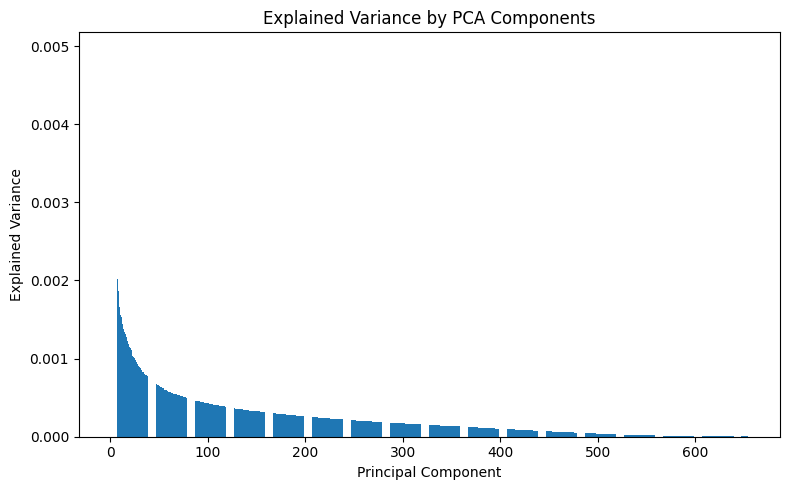

In [20]:
pca = PCA(n_components=None)
pca.fit(dense_train_encodings_df)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.tight_layout()
plt.show()

Based on this visual distribution of principal components variance, we use the elbow rule and keep no more than 100 components.

In [21]:
# A quick variance display on the first 100 components
print(f"min variance = {min(pca.explained_variance_[0:100])}, max variance = {max(pca.explained_variance_[0:100])}, mean variance = {np.mean(pca.explained_variance_[0:100])}")

min variance = 0.00042917352402582765, max variance = 0.004929742310196161, mean variance = 0.000929633155465126


In [22]:
NUM_COMP_DENSE = 100
pca = PCA(n_components=NUM_COMP_DENSE)
pca.fit(dense_train_encodings_df)

final_dense_train_encodings_df = pd.DataFrame(data=pca.fit_transform(dense_train_encodings_df))

final_dense_train_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.024872,0.070602,-0.074719,0.017038,0.089526,0.061701,-0.039945,-0.007048,0.045465,0.018776,...,-0.000848,-0.026366,-0.028772,-0.004956,0.026733,0.011401,0.026989,0.031488,0.034290,0.033025
1,-0.043383,0.154111,0.064250,0.019819,0.089233,0.000905,0.070194,-0.011236,0.007626,0.069976,...,0.008234,-0.001008,-0.014240,0.033895,-0.010916,-0.010899,-0.021789,-0.001291,-0.016627,0.021072
2,0.010381,0.053172,0.103535,-0.033648,0.084949,-0.007888,0.028152,-0.020035,0.039959,0.009685,...,-0.045485,0.003317,-0.032858,0.003871,-0.031708,-0.021043,0.007191,-0.030804,-0.010244,-0.020463
3,-0.062919,-0.023417,0.080963,-0.054756,-0.030716,-0.054085,0.014107,0.057365,-0.010471,-0.034497,...,0.009424,-0.029684,0.010171,-0.013076,0.006194,0.013754,-0.013272,-0.001595,0.000549,-0.016778
4,0.050883,-0.019973,-0.023052,0.090220,-0.058819,-0.030474,0.044467,-0.036819,0.037841,0.043519,...,-0.008761,0.021295,0.024893,-0.000436,-0.015840,-0.011431,0.001609,-0.010019,0.005992,-0.009523


In [23]:
final_sparse_train_encodings_df = sparse_train_encodings_df.copy()

final_sparse_train_encodings_df.head()

,101,999
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [24]:
X_train = pd.concat([final_dense_train_encodings_df, final_sparse_train_encodings_df], axis=1)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,101,999
0,-0.024872,0.070602,-0.074719,0.017038,0.089526,0.061701,-0.039945,-0.007048,0.045465,0.018776,...,-0.028772,-0.004956,0.026733,0.011401,0.026989,0.031488,0.034290,0.033025,0.0,0.0
1,-0.043383,0.154111,0.064250,0.019819,0.089233,0.000905,0.070194,-0.011236,0.007626,0.069976,...,-0.014240,0.033895,-0.010916,-0.010899,-0.021789,-0.001291,-0.016627,0.021072,0.0,0.0
2,0.010381,0.053172,0.103535,-0.033648,0.084949,-0.007888,0.028152,-0.020035,0.039959,0.009685,...,-0.032858,0.003871,-0.031708,-0.021043,0.007191,-0.030804,-0.010244,-0.020463,0.0,0.0
3,-0.062919,-0.023417,0.080963,-0.054756,-0.030716,-0.054085,0.014107,0.057365,-0.010471,-0.034497,...,0.010171,-0.013076,0.006194,0.013754,-0.013272,-0.001595,0.000549,-0.016778,0.0,0.0
4,0.050883,-0.019973,-0.023052,0.090220,-0.058819,-0.030474,0.044467,-0.036819,0.037841,0.043519,...,0.024893,-0.000436,-0.015840,-0.011431,0.001609,-0.010019,0.005992,-0.009523,0.0,0.0


In [25]:
y_train = train_df['label']

y_train.head()

0     alcoholism
1            bpd
2            bpd
3           ptsd
4    EDAnonymous
Name: label, dtype: category
Categories (16, object): ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', ..., 'ptsd', 'schizophrenia',
                          'socialanxiety', 'suicidewatch']

Later, the reproduced pipeline to use for the test set will be :
- Compute its dense and sparse embeddings.
- Keep columns at the same indexes as those ones after variance selection for both embeddings types.
- Compute the first 100 pca components from dense embeddings kept.
- Join the 100 pca components computed from dense embeddings kept with the two columns kept for sparse embeddings after variance selection.

## Train a CatBoost classifier on embeddings

We train a CatBoost classifier with basics hyperparameters and analyze its performance by cross-validation. 

Some adavantages of this model is that we do not need to encode the target in any way, and it doesn't need much tuning on its hyperparameters.

For any info on this model, your refer to this link [CatBoost](https://catboost.ai/docs/en/).

In [26]:
train_pool = Pool(X_train, y_train)

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': None,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'random_seed': SEED,
    'verbose': True
}

cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=K_FOLDS,
    shuffle=True,
    partition_random_seed=SEED,
    verbose=True,
    plot=False
)

Training on fold [0/5]
0:	learn: 0.2699197	test: 0.2654798	best: 0.2654798 (0)	total: 734ms	remaining: 1m 12s
1:	learn: 0.3152775	test: 0.3074100	best: 0.3074100 (1)	total: 1.5s	remaining: 1m 13s
2:	learn: 0.3303186	test: 0.3294292	best: 0.3294292 (2)	total: 2.17s	remaining: 1m 10s
3:	learn: 0.3563964	test: 0.3519169	best: 0.3519169 (3)	total: 2.92s	remaining: 1m 10s
4:	learn: 0.3805794	test: 0.3754197	best: 0.3754197 (4)	total: 3.62s	remaining: 1m 8s
5:	learn: 0.3922216	test: 0.3827594	best: 0.3827594 (5)	total: 4.28s	remaining: 1m 7s
6:	learn: 0.4005626	test: 0.3940033	best: 0.3940033 (6)	total: 4.95s	remaining: 1m 5s
7:	learn: 0.4088840	test: 0.4007964	best: 0.4007964 (7)	total: 5.61s	remaining: 1m 4s
8:	learn: 0.4120290	test: 0.4050129	best: 0.4050129 (8)	total: 6.28s	remaining: 1m 3s
9:	learn: 0.4206825	test: 0.4151636	best: 0.4151636 (9)	total: 6.96s	remaining: 1m 2s
10:	learn: 0.4274022	test: 0.4221129	best: 0.4221129 (10)	total: 7.63s	remaining: 1m 1s
11:	learn: 0.4331061	test:

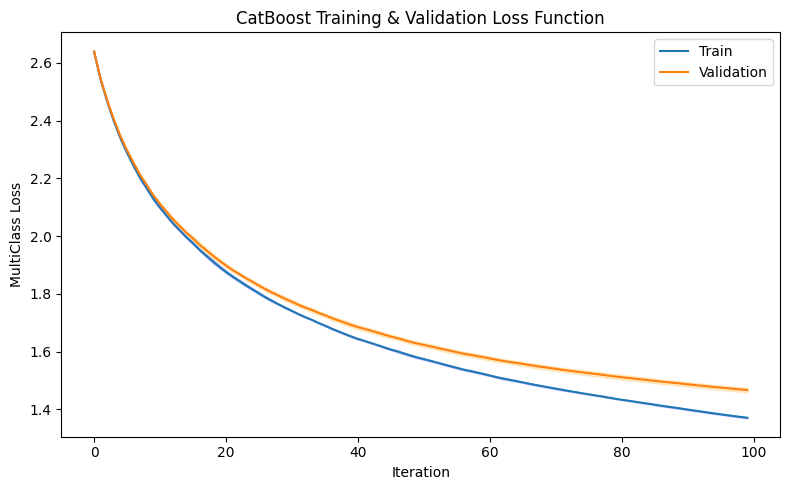

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(cv_results['train-MultiClass-mean'], label='Train')
plt.plot(cv_results['test-MultiClass-mean'], label='Validation')
plt.fill_between(
    range(len(cv_results)),
    cv_results['train-MultiClass-mean'] - cv_results['train-MultiClass-std'],
    cv_results['train-MultiClass-mean'] + cv_results['train-MultiClass-std'],
    alpha=0.2,
    color='blue'
)
plt.fill_between(
    range(len(cv_results)),
    cv_results['test-MultiClass-mean'] - cv_results['test-MultiClass-std'],
    cv_results['test-MultiClass-mean'] + cv_results['test-MultiClass-std'],
    alpha=0.2,
    color='orange'
)
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss Function')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
print('Monitoring loss function during training-validation :')
print(f" - During training : {np.mean(cv_results['train-MultiClass-mean'])} +/- {np.mean(cv_results['train-MultiClass-std'])}")
print(f" - During validation : {np.mean(cv_results['test-MultiClass-mean'])} +/- {np.mean(cv_results['test-MultiClass-std'])}")

Monitoring loss function during training-validation :
 - During training : 1.6749884871429392 +/- 0.0028094551674129648
 - During validation : 1.724386891573895 +/- 0.007134280250008827


In [29]:
print('Monitoring accuracy during training-validation :')
print(f" - During training : {np.mean(cv_results['train-Accuracy-mean'])} +/- {np.mean(cv_results['train-Accuracy-std'])}")
print(f" - During validation : {np.mean(cv_results['test-Accuracy-mean'])} +/- {np.mean(cv_results['test-Accuracy-std'])}")

Monitoring accuracy during training-validation :
 - During training : 0.5298480957974949 +/- 0.002083240926456274
 - During validation : 0.5115007843457721 +/- 0.0044739100641736215


- The model's training didn't suffer from any severe overfitting case, and it's able to learn how to predict mental health state based on comments. 
- Let's retrain it using all the training set, then analyze more deeply its predictions.

In [30]:
# Retrain CatBoost model on the whole training data
catboost_model = CatBoostClassifier(**params)
catboost_model.fit(X_train, y_train, verbose=10)

0:	learn: 0.2688125	total: 805ms	remaining: 1m 19s
10:	learn: 0.4324375	total: 9.32s	remaining: 1m 15s
20:	learn: 0.4827187	total: 18.3s	remaining: 1m 8s
30:	learn: 0.5144219	total: 27s	remaining: 1m
40:	learn: 0.5347969	total: 35.4s	remaining: 50.9s
50:	learn: 0.5518125	total: 43.6s	remaining: 41.9s
60:	learn: 0.5637031	total: 51.7s	remaining: 33.1s
70:	learn: 0.5750156	total: 1m	remaining: 24.5s
80:	learn: 0.5849375	total: 1m 8s	remaining: 16s
90:	learn: 0.5933125	total: 1m 16s	remaining: 7.53s
99:	learn: 0.5995938	total: 1m 23s	remaining: 0us


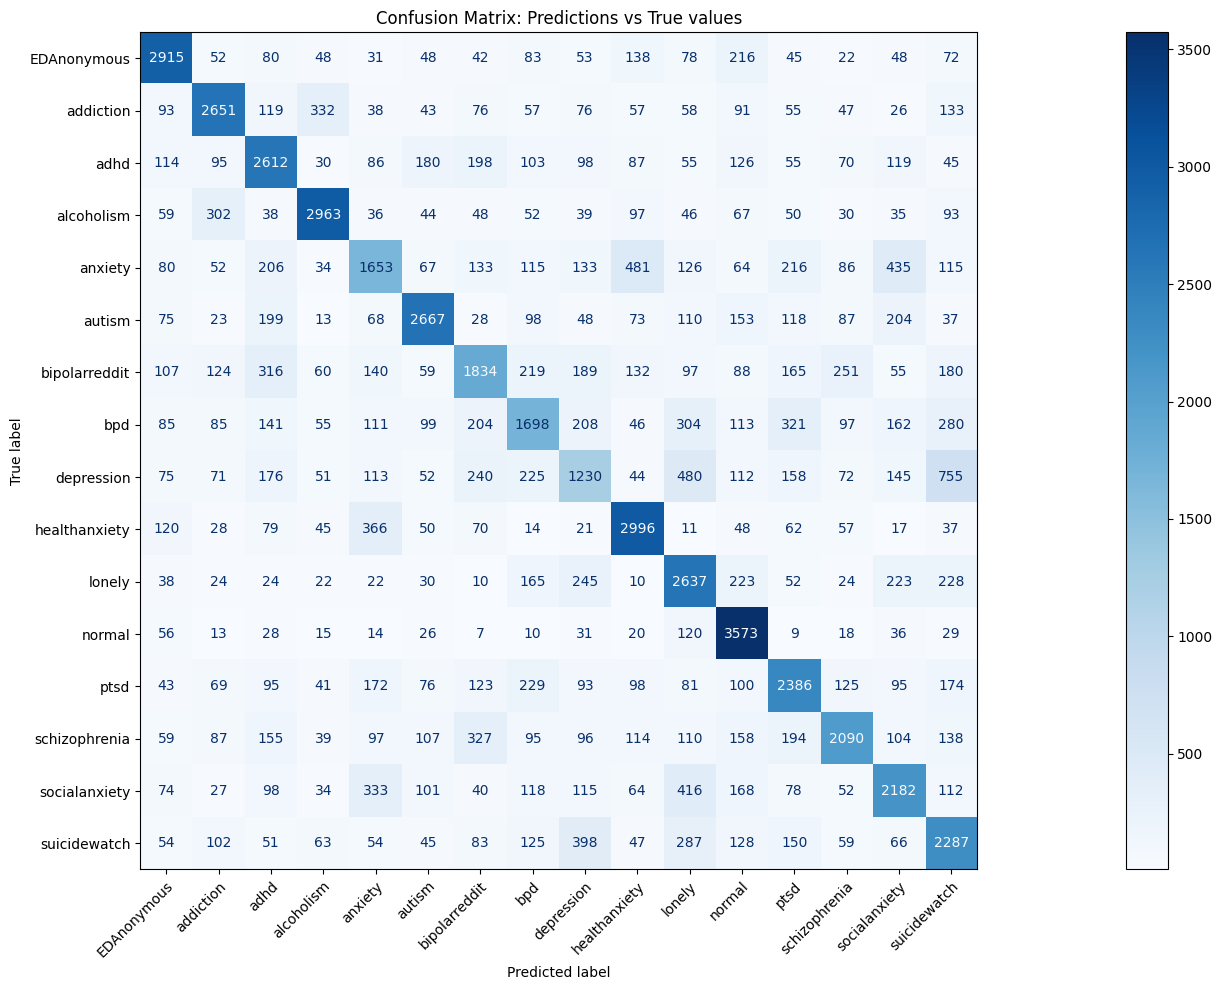

In [31]:
y_train_pred = catboost_model.predict(X_train)
class_names = list(y_train.cat.categories)

cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(30, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax) 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Confusion Matrix: Predictions vs True values")

plt.tight_layout()
plt.show()

Even though in general the model's accuracy seems really good, when analyzing confusion matrix we could detect mental health issues where some number of false positives seem relevant despite having quite large values of true positives.

## Performance on unseen data (test data)

Text Engineering + Embeddings reduction

In [32]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time

# + Variance selection

try:
    dense_test_encodings_df = pd.DataFrame(np.load('dense_test_encodings.npy'))
except FileNotFoundError:
    dense_test_encodings_df = dense_model.encode(sentences=test_df['text'], truncate_dim=MAX_DIM_DENSE, show_progress_bar=True)
    # Do variance selection
    dense_test_encodings_df = dense_test_encodings_df[:, INDEX_DENSE]
    np.save('dense_test_encodings.npy', dense_test_encodings_df)
    dense_test_encodings_df = pd.DataFrame(dense_test_encodings_df)    

# Downcast numeric columns to reduce memory usage
dense_test_encodings_df = dense_test_encodings_df.select_dtypes(include=[float, int]).astype('float32')

# Do pca reduction using saved NUM_COMP_DENSE from training
pca = PCA(n_components=NUM_COMP_DENSE)
pca.fit(dense_test_encodings_df)
final_dense_test_encodings_df = pd.DataFrame(data=pca.fit_transform(dense_test_encodings_df))

assert final_dense_train_encodings_df.columns.equals(final_dense_test_encodings_df.columns), 'Reproduced pipeline failed !!!'
final_dense_test_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.031725,-0.007927,0.042497,0.044835,-0.060171,-0.017443,-0.011381,0.000564,0.072236,0.016592,...,-0.001741,0.007753,-0.008739,0.000838,0.001849,-0.013562,-0.028515,0.020649,-0.019024,-0.023644
1,0.091486,0.069406,-0.098255,-0.058172,-0.014813,-0.043779,-0.049564,-0.018815,0.019305,-0.034594,...,0.033101,0.011520,0.023523,0.006739,-0.002028,-0.013410,0.071742,0.026794,0.032517,-0.034202
2,-0.020966,-0.051349,0.050294,-0.051325,0.150238,0.049773,0.044212,0.003355,0.000338,-0.044489,...,-0.006755,-0.047924,-0.024390,-0.013362,-0.041733,0.017244,0.018306,0.007198,-0.020194,-0.011786
3,-0.013367,-0.130760,-0.092978,-0.013061,-0.040664,-0.079021,-0.049498,0.075147,-0.004527,0.057777,...,0.004345,0.011107,0.027753,0.027558,0.004836,-0.024684,-0.002590,0.020188,-0.012775,0.010083
4,0.004033,0.083842,-0.007073,0.034271,0.064638,0.058015,-0.036666,0.021372,-0.002128,0.006039,...,0.003168,-0.005735,0.026062,0.000673,0.027512,-0.001622,0.008011,0.006037,0.029319,0.006376


In [33]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time

# + Variance selection

try:
    sparse_test_encodings_df = pd.DataFrame(np.load('sparse_test_encodings.npy'))
    sparse_test_encodings_df = pd.DataFrame(data=sparse_test_encodings_df.values, columns=final_sparse_train_encodings_df.columns)   
except FileNotFoundError:
    sparse_test_encodings_df = sparse_model.encode_document(sentences=test_df['text'], show_progress_bar=True).to_dense().numpy()
    # Do variance selection
    sparse_test_encodings_df = sparse_test_encodings_df[:, INDEX_SPARSE]
    np.save('sparse_test_encodings.npy', sparse_test_encodings_df)
    sparse_test_encodings_df = pd.DataFrame(data=sparse_test_encodings_df, columns=final_sparse_train_encodings_df.columns)    

# Downcast numeric columns to reduce memory usage
sparse_test_encodings_df = sparse_test_encodings_df.select_dtypes(include=[float, int]).astype('float32')

# No pca reduction needed since only one column is kept at the end
final_sparse_test_encodings_df = sparse_test_encodings_df.copy()

assert final_sparse_train_encodings_df.columns.equals(final_sparse_test_encodings_df.columns), 'Reproduced pipeline failed !!!'
final_sparse_test_encodings_df.head()

,101,999
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [34]:
X_test = pd.concat([final_dense_test_encodings_df, final_sparse_test_encodings_df], axis=1)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,101,999
0,-0.031725,-0.007927,0.042497,0.044835,-0.060171,-0.017443,-0.011381,0.000564,0.072236,0.016592,...,-0.008739,0.000838,0.001849,-0.013562,-0.028515,0.020649,-0.019024,-0.023644,0.0,0.0
1,0.091486,0.069406,-0.098255,-0.058172,-0.014813,-0.043779,-0.049564,-0.018815,0.019305,-0.034594,...,0.023523,0.006739,-0.002028,-0.013410,0.071742,0.026794,0.032517,-0.034202,0.0,0.0
2,-0.020966,-0.051349,0.050294,-0.051325,0.150238,0.049773,0.044212,0.003355,0.000338,-0.044489,...,-0.024390,-0.013362,-0.041733,0.017244,0.018306,0.007198,-0.020194,-0.011786,0.0,0.0
3,-0.013367,-0.130760,-0.092978,-0.013061,-0.040664,-0.079021,-0.049498,0.075147,-0.004527,0.057777,...,0.027753,0.027558,0.004836,-0.024684,-0.002590,0.020188,-0.012775,0.010083,0.0,0.0
4,0.004033,0.083842,-0.007073,0.034271,0.064638,0.058015,-0.036666,0.021372,-0.002128,0.006039,...,0.026062,0.000673,0.027512,-0.001622,0.008011,0.006037,0.029319,0.006376,0.0,0.0


In [35]:
y_test = test_df['label']
y_test.head()

0        anxiety
1         normal
2     alcoholism
3    EDAnonymous
4        anxiety
Name: label, dtype: category
Categories (16, object): ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', ..., 'ptsd', 'schizophrenia',
                          'socialanxiety', 'suicidewatch']

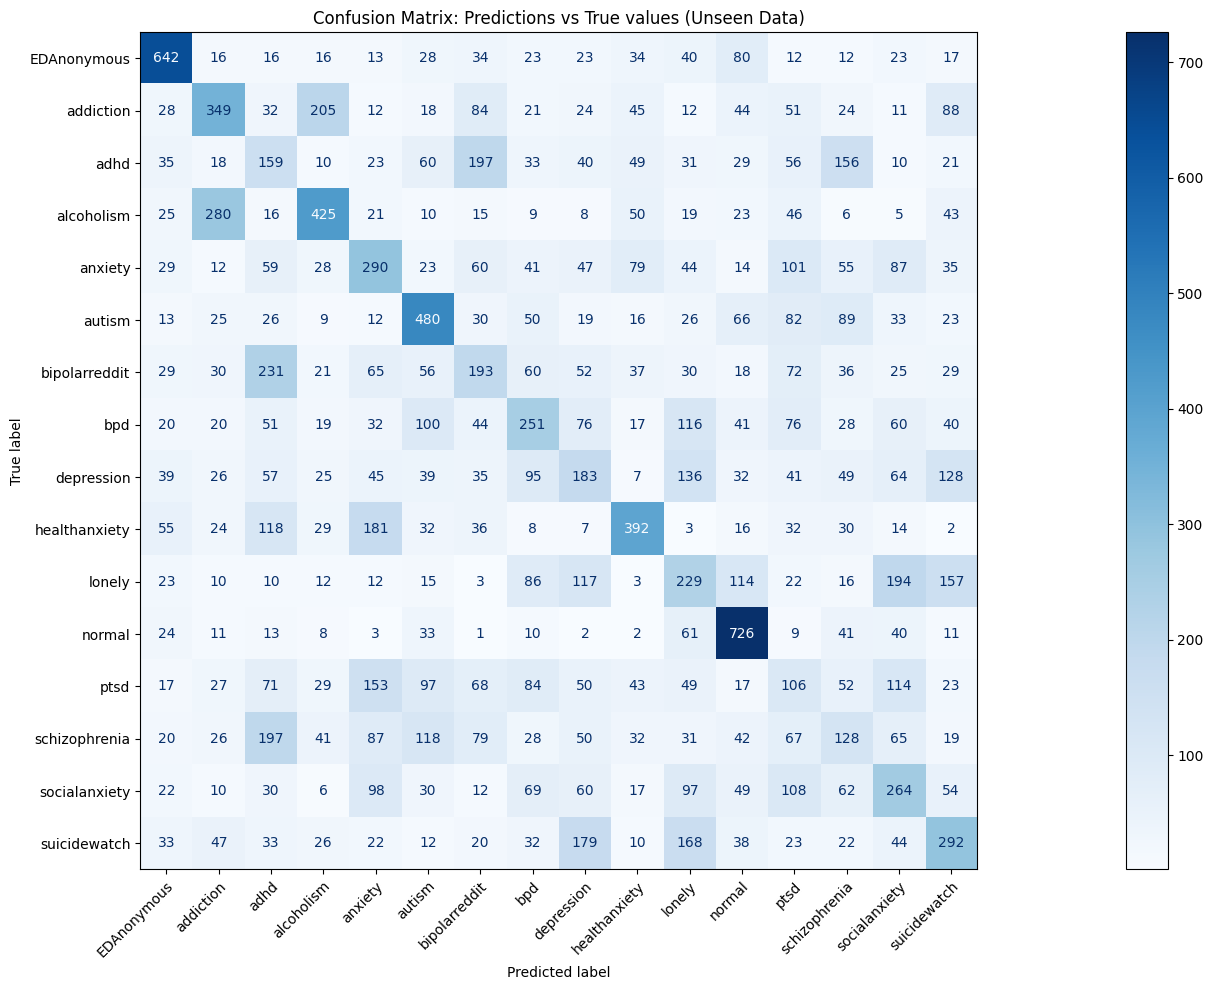

In [36]:
y_test_pred = catboost_model.predict(X_test)
class_names = list(y_test.cat.categories)

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(30, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax) 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Confusion Matrix: Predictions vs True values (Unseen Data)")

plt.tight_layout()
plt.show()

In [37]:
print(f"Accuracy: {(cm.trace() / cm.sum()):.4f}")

Accuracy: 0.3193


- Even though no overfitting was displayed during the training and quite good performance (~60%) was obtained, performance on new data is quite low (~30% accuracy).
- We do not proceed further for this case, and look for using more advanced models.